# Binary evolutions for the progenitor of J08408

Study of grid of binaries with a NS orbiting around a massive star. The aim of this notebook is to present a clear picture on the parameters which are related to J08408

## Configuration

In [1]:
save_figures = False

use_paper_style = False

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
from matplotlib.ticker import MultipleLocator
from scipy.optimize import bisect
import pandas as pd
from scipy import interpolate
from scipy.stats import maxwell
import seaborn as sns

from utils import *

# some constants
one_third = 1e0 / 3e0
pi = 3.1415926535897932384626433832795028841971693993751e0
standard_cgrav = 6.67428e-8
Msun = 1.9892e33
Rsun = 6.9598e10
Hubble_time = 13.461701658024014e0  # Gyr
clight = 2.99792458e10
secyer = 3.1558149984e7

# ---------------------------------------------
# Set some global options
np.seterr(all="ignore")

# colors & possible termination codes
end_colors = ["tomato", "firebrick", "steelblue"]
codes_dict = {
    "ce_merge": "CE phase",
    "high_atm_mdot": "$\\dot{M}_{\\rm RLOF} > \\dot{M}_{\\rm thres}$",
    "sn_merge": "asymmetric SN $\\longrightarrow$ merge",
}

# ---------------------------------------------
# Load data
root = ".."
run_location = f"{root}/data/natal-kicks"
mesa_run_location = f"{root}/data"
config_location = f"{root}/config"

# complete kick distribution (id, w, theta, phi)
id_distro, w_distro, theta_distro, phi_distro = np.loadtxt(
    f"{run_location}/kicks-distribution.data", skiprows=1, unpack=True
)

# 2D grid in the plane (P, e) corresponding to small squares with >90% of occurence
id_grid, p_grid, a_grid, e_grid, prob_grid = np.loadtxt(
    f"{run_location}/target_orbits.data", skiprows=9, unpack=True
)

# complete set of possible orbits for bounded binaries after aplying the complete
# kick distribution
id_allorbits, p_allorbits, a_allorbits, e_allorbits, w_allorbits, theta_allorbits, phi_allorbits = np.loadtxt(
    f"{run_location}/all_orbits.data", skiprows=1, unpack=True
)

# load summary of mesa simulations
summary_of_progenitors = pd.read_csv(
    f"{mesa_run_location}/summary_of_star_plus_ns.data",
    delim_whitespace=True,
    skiprows=3,
)

# load additional information for each run (time as XRB, Mdot_acc, min(chi2))
additional_info_on_progenitors = pd.read_csv(
    f"{mesa_run_location}/additional_info_of_star_plus_ns.data", delim_whitespace=True
)

# detail binary evolution of models with low chi2 value (very similar in parameters as J08408)
detail_progenitors = pd.read_csv(
    f"{mesa_run_location}/details_of_progenitors_of_j08408.data", delim_whitespace=True
)

# matplotlib styles
mpl_style = f"{config_location}/style.mpl"
paper_style = f"{config_location}/paper-style.mpl"

## Parameters at core collapse

In [3]:
m1precc = 8.3525627823294126e000
m2precc = 3.2637938645139933e001
aprecc = 7.3604203503769526e001
pprecc = 1.1424984631360623e001
r1precc = 2.4346822488037647e000
r2precc = 1.8891193348004055e001
remnantmass = 1.6601196874643882e000

## Kepler law & some auxiliary functions

In [4]:
def a_to_P(separation, m1, m2):
    """Kepler law to go from separation to orbital period

    Parameters
    ----------
    a: binary separation in [Rsun]
    m1: mass of primary star in [Msun]
    m2: mass of secondary star in [Msun]

    Returns
    -------
    period: orbital period in [days]
    """
    separation = separation * Rsun  # in cm
    m1 = m1 * Msun
    m2 = m2 * Msun  # in g

    period = (
        2 * np.pi * np.sqrt(separation**3 / (standard_cgrav * (m1 + m2))) / (86400.0)
    )
    return period


def P_to_a(period, m1, m2):
    """
    Binary separation from known period

    Parameters
    ----------
    P: binary period in [days]
    M1: mass of primary star in [Msun]
    M2: mass of secondary star in [Msun]

    Returns
    -------
    a: binary separation in [Rsun]
    """
    period = period * 24e0 * 3600e0  # in sec
    m1 = m1 * Msun
    m2 = m2 * Msun  # in g
    tmp = standard_cgrav * (m1 + m2) * (period / (2 * np.pi)) ** 2
    separation = np.power(tmp, one_third)
    return separation / Rsun


def rlobe(m1, m2, separation):
    """Roche lobe approximation for a star using Eggleton (1983)
    formula

    Parameters
    ----------
    m1: mass of primary star in [Msun]
    m2: mass of secondary star in [Msun]
    separation: binary separation in [Rsun]

    Returns
    -------
    RL: Roche lobe of primary star in [Rsun]
    """
    one_third = 1e0 / 3e0
    q = np.power(m1 / m2, one_third)
    RL = 0.49e0 * q**2 / (0.6 * q**2 + np.log(1 + q))
    RL = separation * RL

    return RL


def get_line_of_constant_w(w):
    """For a given kick velocity, get orbital parameters matching velocity with a different
    set of theta values (angle in the orbital plane)

    Parameters
    ----------
    w : strength of the kick in [km s-1]

    Returns
    -------
    period : orbital period in [days]
    eccentricity : eccentricity of the binary
    """
    # get period & eccentricity from linear momentum conservation
    _, P_f, e_f, _, _, _, _, _, _ = binary_orbits_after_kick(
        aprecc, m1precc, m2precc, remnantmass, w, theta_distro, 0, id_distro
    )

    # interpolate (this do not work for fixed theta values, just for kick strength)
    f = interpolate.interp1d(P_f, e_f)

    # now use the interpolation to get lines of constant w
    xmin = np.min(P_f)
    xmax = np.max(P_f)
    xnew = np.logspace(np.log10(xmin), np.log10(xmax - 1), 1000)
    return xnew, f(xnew), f


def get_line_of_constant_theta(theta, boundary=None, value=None):
    """For a given theta angle, get orbital parameters matching angle with a different
    set of kick velocity values

    Parameters
    ----------
    theta : angle of the kick in the orbital plane in the interval [0, 2*pi)

    Returns
    -------
    period : orbital period in [days]
    eccentricity : eccentricity of the binary
    """
    # get period & eccentricity from linear momentum conservation
    _, P_f, e_f, _, _, _, _, _, _ = binary_orbits_after_kick(
        aprecc, m1precc, m2precc, remnantmass, w_distro[:10000], theta, 0, id_distro[:10000]
    )

    # interpolate (this do not work for fixed theta values, just for kick strength)
    if boundary is "below":
        mask = e_f < value
        P_f = P_f[mask]
        e_f = e_f[mask]
    elif boundary is "above":
        mask = e_f > value
        P_f = P_f[mask]
        e_f = e_f[mask]

    f = interpolate.interp1d(P_f, e_f)

    # now use the interpolation to get lines of constant w
    xmin = np.min(P_f)
    xmax = np.max(P_f)
    xnew = np.logspace(np.log10(xmin), np.log10(xmax - 1), 1000)
    return xnew, f(xnew), f


def get_lines_of_constant_RRL(R_div_RL):
    """Line of constant ratio R/RL of a star in a binary

    Parameters
    ----------

    Returns
    -------
    """
    # constant lines of RLOF
    ecc_max = 0.999
    ecs = np.linspace(0, ecc_max)
    a_for_R_div_RL = np.zeros(len(ecs))
    a = np.logspace(-1, 4)
    for i, e in enumerate(ecs):
        f = lambda a: r2precc / (rlobe(m2precc, remnantmass, a) * (1 - e)) - R_div_RL
        a_for_R_div_RL[i] = bisect(f, a=0, b=1e6, maxiter=100)

    mask = a_for_R_div_RL > m2precc / (1 + ecs)
    return a_to_P(a_for_R_div_RL[mask], m2precc, remnantmass), ecs[mask]


def summary_with_patches(df, fig, ax):
    """Make plot of summary"""

    dbg = False

    # borders of grid of orbital periods
    porb_borders = np.logspace(np.log10(4.42), np.log10(1745.02), 51)

    for k in df.index:
        porbk = df["porb_pm"].iloc[k]
        ecck = df["e_pm"].iloc[k]
        string = df["termination_code_pm"].iloc[k]

        if string == "ce_merge":
            state = "tomato"
        elif string == "high_atm_mdot":
            state = "firebrick"
        elif string == "sn_merge":
            state = "steelblue"
        else:
            print(f"unknown termination code for index {k}")

        # find width from borders array
        pkmin = np.argmin(np.abs(porbk - porb_borders))
        width = porb_borders[pkmin + 1] - porb_borders[pkmin]

        # in case of problems return
        if porbk < porb_borders[pkmin]:
            print(
                f"lower boundary of porb cannot be larger than actual value: {porbk}, {porb_borders[pkmin]}"
            )
            return None, None

        # find heigth from borders array
        height = 0.02

        if dbg:
            print(
                f"porb case: {porbk:.2f} [{width}]; [{porb_borders[pkmin]},{porb_borders[pkmin+1]}]"
            )

        rect = patches.Rectangle(
            (porbk - width, ecck - height),
            width=width,
            height=height,
            facecolor=state,
            lw=0,
            edgecolor="black",
            zorder=-1
        )

        ax.add_patch(rect)

    return fig, ax

---

## Statistic on kicks distribution

In [5]:
# get some numbers to make some statistics
total_kicks = len(id_distro)
total_bounded_binaries = 384893  # from file `all_orbits.data`
total_disrupted_binaries = total_kicks - total_bounded_binaries

sn_merge_orbits = np.zeros(len(p_allorbits))
rlof_orbits = np.zeros(len(p_allorbits))
for k, e_tmp in enumerate(e_allorbits):
    # temp vars
    a_tmp = a_allorbits[k]
    porb_tmp = p_allorbits[k]
    
    # find out how many are above the limit for SN merger
    emax_tmp = 1 - (r2precc / a_tmp)
    if e_tmp > emax_tmp: sn_merge_orbits[k] = 1

    # find out how many have R/RL > 1 but without entering the SN merger regime
    R_div_RL_tmp = r2precc / rlobe(m2precc, remnantmass, a_tmp * (1 - e_tmp))
    if R_div_RL_tmp > 1 and sn_merge_orbits[k] < 1: rlof_orbits[k] = 1

total_sn_merger = len(e_allorbits[abs(sn_merge_orbits - 1) < 1e-10])
total_rlof = len(e_allorbits[abs(rlof_orbits - 1) < 1e-10])
total_no_rlof = len(e_allorbits[abs(rlof_orbits - 0) < 1e-10])

print(f"total kicks: {total_kicks}")
print(f"total disruptions: {total_disrupted_binaries}")
print(f"total bounded: {total_bounded_binaries}")
print(f"total SN mergers: {total_sn_merger}")
print(f"total RLOF: {total_rlof}")
print(f"total no RLOF: {total_no_rlof}")

total kicks: 1000000
total disruptions: 615107
total bounded: 384893
total SN mergers: 117596
total RLOF: 52172
total no RLOF: 332358


---

## Basic summary

#### replace some termination codes to take into account SN mergers

A SN merger is defined as a binary in which the periastron post kick is smaller than the radius of the star:

\begin{equation}
    a_{\rm post-CC} \times (1 - e_{\rm post-CC}) < R_{\rm companion}
\end{equation}

In [6]:
def check_for_sn_merge(DataFrame):
    """Look for SN merge in the sample of MESA runs
    
    A SN merge is defined as binaries where: a_f = a_i * (1 - e) < R_2
    """
    
    for k in range(len(DataFrame)):
        if DataFrame["a_pm"].iloc[k] * (1 - DataFrame["e_pm"].iloc[k]) < r2precc:
            DataFrame["termination_code_pm"].iloc[k] = "sn_merge"
    
    return DataFrame

In [7]:
summary_of_progenitors = check_for_sn_merge(summary_of_progenitors)

In [8]:
codes = list(set(summary_of_progenitors["termination_code_pm"]))
for code in codes:
    mask = summary_of_progenitors["termination_code_pm"] == code
    print("{}:".format(code), "n-simulations =", len(summary_of_progenitors[mask]))

high_atm_mdot: n-simulations = 390
sn_merge: n-simulations = 292
ce_merge: n-simulations = 237


---

## Details of how simulations ended

### Outcome of simulations and some information on the binaries as well as theoretical limits on the ($P, e$) plane

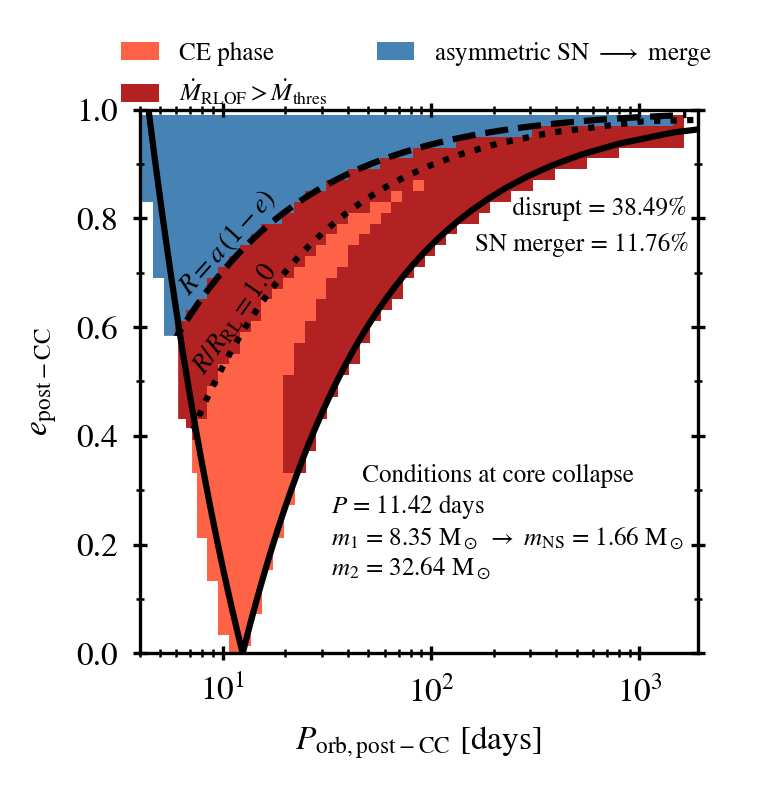

In [9]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()
ax.set_xscale("log")

# axis labels
ax.set_xlabel("$P_{\\rm orb, post-CC}$ [days]")
ax.set_ylabel("$e_{\\rm post-CC}$")

# axis limits & ticks
ax.set_xlim(4, 1.9e3)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(0, 1)
ax.tick_params("y", reset=True, zorder=99)

# theoretical limits
ecc_max = 0.999
ecs = np.linspace(0, ecc_max)
ax.plot(
    a_to_P(aprecc / (1 + ecs), m2precc, remnantmass),
    ecs,
    ls="-",
    c="black",
    zorder=99,
)
ax.plot(
    a_to_P(aprecc / (1 - ecs), m2precc, remnantmass),
    ecs,
    ls="-",
    c="black",
    zorder=99,
)

# MESA runs
fig, ax = summary_with_patches(summary_of_progenitors, fig, ax)

# lines of constant R/RL
ptmp, etmp = get_lines_of_constant_RRL(1.0)
ax.plot(ptmp, etmp, color="black", ls=":", zorder=0)

# limit on minimum separation (period) due to the presence of non-compact companion
# a_f * (1 - e) = R_2 => e = 1 - (R_2 / a_f)
porbs = np.logspace(np.log10(np.min(p_grid)), np.log10(np.max(p_grid)))
eccmaxs = 1 - (r2precc / P_to_a(porbs, remnantmass, m2precc))
ax.plot(porbs, eccmaxs, color="black", ls="--", zorder=0)

# fill between to hide ugly lines of R/RL outside of "V" shape
ax.fill_between([4.0, 7], 0.01, 0.41, color="white", zorder=1)
ax.fill_between([4.0, 6], 0.01, 0.58, color="white", zorder=1)
ax.fill_between([4.0, 6], 0.01, 0.58, color="white", zorder=1)

# text on R/RL lines
ax.annotate(
    "$R/R_{} = {}$".format("{\\rm RL}", 1.0),
    xy=(0.26, 0.58),
    xycoords="figure fraction",
    zorder=99,
    rotation=55,
    fontsize=6.5
)
ax.annotate(
    "$R = a \\, (1 - e)$",
    xy=(0.24, 0.69),
    xycoords="figure fraction",
    zorder=99,
    rotation=48,
    fontsize=6.5
)

# information on the distribution of kicks
ax.annotate(
    f"      disrupt = {total_bounded_binaries * 100 / total_kicks:.2f}%",
    xy=(0.66, 0.8),
    xycoords="figure fraction",
    zorder=99,
    fontsize=6
)
ax.annotate(
    f"SN merger = {total_sn_merger * 100 / total_kicks:.2f}%",
    xy=(0.66, 0.75),
    xycoords="figure fraction",
    zorder=99,
    fontsize=6
)

# text on conditions at CC
ax.annotate(
    "     Conditions at core collapse\n{} = {:.2f} {}\n{} = {:.2f} {} {} {} = {:.2f} {}\n{} = {:.2f} {}".format(
        "$P$",
        pprecc,
        "days",
        "$m_1$",
        m1precc,
        "M$_\\odot$",
        "$\\rightarrow$",
        "$m_{\\rm NS}$",
        remnantmass,
        "M$_\\odot$",
        "$m_2$",
        m2precc,
        "M$_\\odot$",
    ),
    fontsize=6,
    xy=(0.46, 0.30),
    xycoords="figure fraction",
)

# legends
handles = [patches.Patch(color=color, lw=0) for color in end_colors]
legends = ["{}".format(codes_dict[event]) for event in codes_dict.keys()]
fig.legend(handles, legends, loc="center", ncol=2, bbox_to_anchor=(0.51, 0.93))

if True:
    plt.savefig("summary_star_plus_ns.pdf")

## Most similar binaries as J08408

Using a chi-square method, we can estimate which cases have binary parameters similar to J08408

In [10]:
def progenitors_with_patches(df, fig, ax, cmap, bounds, sm):
    """Make plot of summary"""

    dbg = False

    # borders of grid of orbital periods
    porb_borders = np.logspace(np.log10(4.42), np.log10(1745.02), 51)
    
    for k in df.index:
        porbk = df["porb"].iloc[k]
        ecck = df["e"].iloc[k]
        nmodels = df["number_of_models"].iloc[k]
        chi2 = df["min_chi2"].iloc[k]
        
        if nmodels <= 1: continue

        if chi2 < 1:
            state = sm.cmap(0.0)
        elif chi2 < 2:
            state = sm.cmap(0.3)
        elif chi2 < 3:
            state = sm.cmap(0.7)
        else:
            state = sm.cmap(1.0)
            
        # find width from borders array
        pkmin = np.argmin(np.abs(porbk - porb_borders))
        width = porb_borders[pkmin + 1] - porb_borders[pkmin]

        # in case of problems return
        if porbk < porb_borders[pkmin]:
            print(
                f"lower boundary of porb cannot be larger than actual value: {porbk}, {porb_borders[pkmin]}"
            )
            return None, None

        # find heigth from borders array
        height = 0.02

        if dbg:
            print(
                f"porb case: {porbk:.2f} [{width}]; [{porb_borders[pkmin]},{porb_borders[pkmin+1]}]"
            )

        rect = patches.Rectangle(
            (porbk - width, ecck - height),
            width=width,
            height=height,
            facecolor=state,
            lw=0,
            edgecolor="black",
            zorder=-1
        )

        ax.add_patch(rect)

    return fig, ax

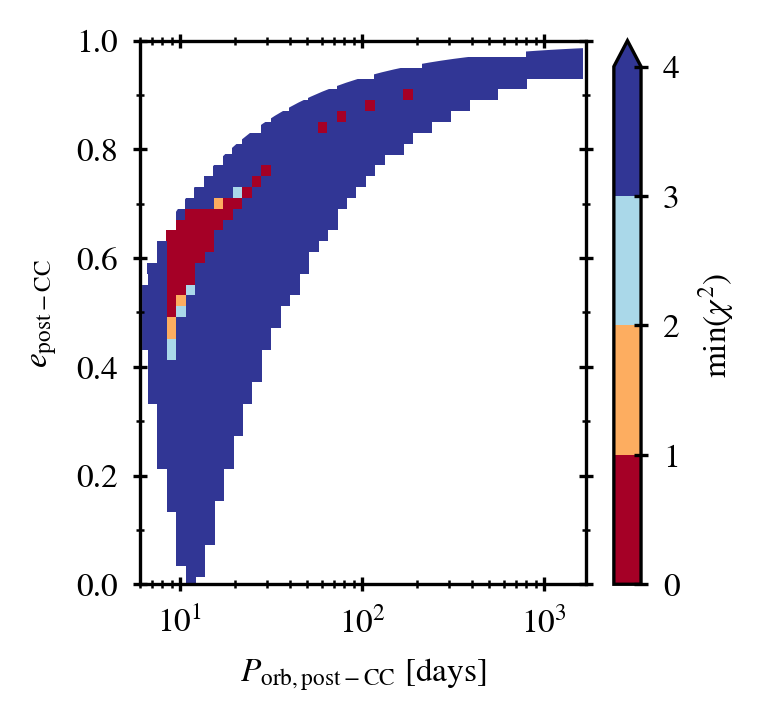

In [11]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()
ax.set_xscale("log")

# axis labels
ax.set_xlabel("$P_{\\rm orb, post-CC}$ [days]")
ax.set_ylabel("$e_{\\rm post-CC}$")

# axis limits
ax.set_xlim(6, 1.7e3)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(0, 1)

# colormap settings
list_cmap_colors = [
    (0.6470588235294118, 0.0, 0.14901960784313725, 1.0),
    (0.9914648212226067, 0.677354863514033, 0.37808535178777386, 1.0),
    (0.6663590926566707, 0.8475970780469052, 0.9118800461361016, 1.0),
    (0.19215686274509805, 0.21176470588235294, 0.5843137254901961, 1.0),
]
cmap = colors.ListedColormap(list_cmap_colors)
# cmap = plt.get_cmap("RdYlBu")
bounds = np.arange(0, 5, 1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# MESA runs using additional information file
progenitors_with_patches(additional_info_on_progenitors, fig, ax, cmap, bounds, sm)
cbar = fig.colorbar(sm, ax=ax, label="$\\min(\\chi^2)$", extend="max")
cbar.minorticks_off()

# limit on minimum separation (period) due to the presence of non-compact companion
# a_f * (1 - e) = R_2 => e = 1 - (R_2 / a_f)
porbs = np.logspace(np.log10(1), np.log10(np.max(p_grid)))
eccmaxs = 1 - (r2precc / P_to_a(porbs, remnantmass, m2precc))
ax.fill_between(porbs, eccmaxs, 1, color="white", zorder=1)
ax.fill_between([4.0, 6], 0.01, 0.6, color="white", zorder=1)

# lines of constant theta
for theta in [np.pi/2, 2*np.pi/3, 3*np.pi/4, np.pi]:
    ls = ":"
    if abs(theta - 3*np.pi/4) < 1e-6:
        x_tmp, y_tmp, _ = get_line_of_constant_theta(theta, "below", 0.75)
        ax.plot(x_tmp, y_tmp, color="black", ls=ls, lw=1, zorder=0.9)
        x_tmp, y_tmp, _ = get_line_of_constant_theta(theta, "above", 0.75)
        ax.plot(x_tmp, y_tmp, color="black", ls=ls, lw=1, zorder=0.9)
    elif abs(theta - 2*np.pi/3) < 1e-6:
        x_tmp, y_tmp, _ = get_line_of_constant_theta(theta, "below", 0.40)
        ax.plot(x_tmp, y_tmp, color="black", ls=ls, lw=1, zorder=0.9)
        x_tmp, y_tmp, _ = get_line_of_constant_theta(theta, "above", 0.34)
        ax.plot(x_tmp, y_tmp, color="black", ls=ls, lw=1, zorder=0.9)
    else:
        break
        x_tmp, y_tmp, _ = get_line_of_constant_theta(theta)
        ax.plot(x_tmp, y_tmp, color="black", ls=ls, lw=1, zorder=0.9)

# lines of constant kick strength
for w in [100, 200, 300]:
    break
    x, y, _ = get_line_of_constant_w(w)
    ax.plot(x, y, color="black", ls="-", lw=1, zorder=0.9)
        
if save_figures:
    plt.savefig("min_chi2.pdf")

---

## Asymmetric kick constraints

In [12]:
# first, grab the values of (Porb, e) which produces possible progenitors
ids = set(detail_progenitors["natal_kick_id"])
porb_pm, a_pm, e_pm = [], [], []
for name in ids:
    porb_pm.append(float(summary_of_progenitors["porb_pm"][summary_of_progenitors["natal_kick_id"] == name]))
    a_pm.append(float(summary_of_progenitors["a_pm"][summary_of_progenitors["natal_kick_id"] == name]))
    e_pm.append(float(summary_of_progenitors["e_pm"][summary_of_progenitors["natal_kick_id"] == name]))

In [13]:
# interpolate data to find the correct value of the natal kick
Pcoords, ecoords = np.meshgrid(porb_pm, e_pm)
w_interp = interpolate.griddata(
            np.vstack((p_allorbits, e_allorbits)).T, w_allorbits, (Pcoords, ecoords), method="nearest"
        )

theta_interp = interpolate.griddata(
            np.vstack((p_allorbits, e_allorbits)).T, theta_allorbits, (Pcoords, ecoords), method="nearest"
        )

phi_interp = interpolate.griddata(
            np.vstack((p_allorbits, e_allorbits)).T, phi_allorbits, (Pcoords, ecoords), method="nearest"
        )

In [14]:
# loop over the interpolated data to extract points matching simulation values
w_pm, theta_pm, phi_pm = [], [], []
for k in range(len(porb_pm)):
    ptmp = porb_pm[k]
    etmp = e_pm[k]
    found = False
    for ke in range(len(ecoords)):
        if abs(ecoords[ke][0] - etmp) < 1e-6:
            for kp in range(len(Pcoords[ke])):
                if abs(Pcoords[ke][kp] - ptmp) < 1e-6:
                    w_pm.append(w_interp[ke][kp])
                    theta_pm.append(theta_interp[ke][kp])
                    phi_pm.append(phi_interp[ke][kp])
                    found = True
                    break
            if found:
                break

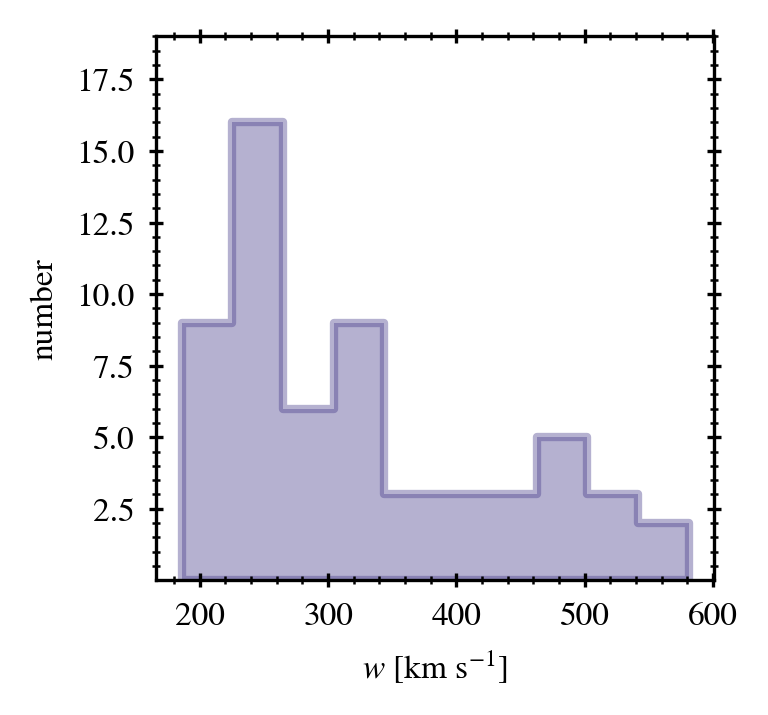

In [15]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()

ax.set_xlabel("$w$ [km s$^{-1}$]")
ax.set_ylabel("number")

ax.set_ylim(0.01, 19)

hist, bin_edges = np.histogram(w_pm)
for k in range(len(hist)):
    hist[k] = hist[k] # / (np.log10(bins[k+1])-np.log10(bins[k]))/np.log(10)
left, right = bin_edges[:-1], bin_edges[1:]

X_Z = np.array([left,right]).T.flatten()
Y_Z = np.array([hist,hist]).T.flatten()

ax.fill_between(X_Z, 1e-6*np.ones(len(Y_Z)), Y_Z, color='darkslateblue', alpha=0.4, linewidth=2);

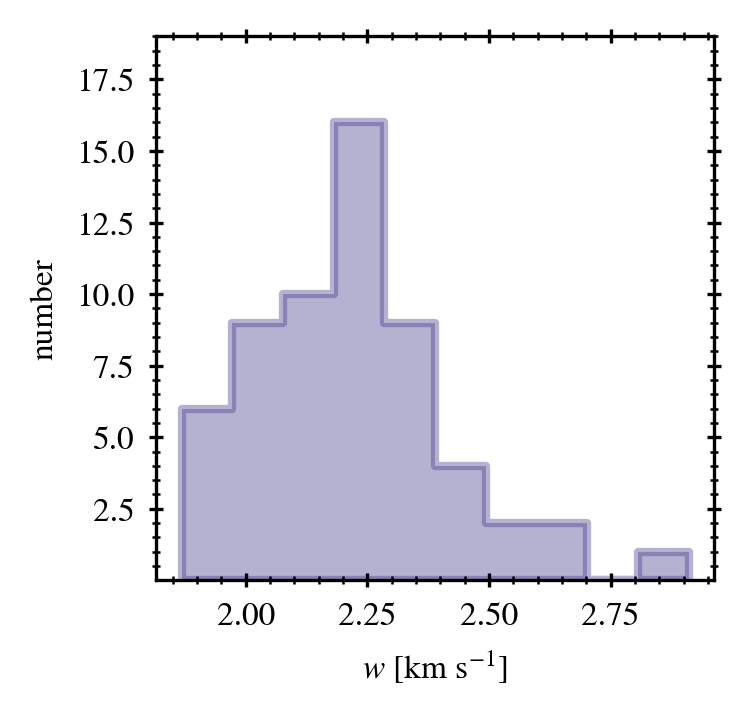

In [16]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()

ax.set_xlabel("$w$ [km s$^{-1}$]")
ax.set_ylabel("number")

ax.set_ylim(0.01, 19)

hist, bin_edges = np.histogram(theta_pm)
for k in range(len(hist)):
    hist[k] = hist[k] # / (np.log10(bins[k+1])-np.log10(bins[k]))/np.log(10)
left, right = bin_edges[:-1], bin_edges[1:]

X_Z = np.array([left,right]).T.flatten()
Y_Z = np.array([hist,hist]).T.flatten()

ax.fill_between(X_Z, 1e-6*np.ones(len(Y_Z)), Y_Z, color='darkslateblue', alpha=0.4, linewidth=2);

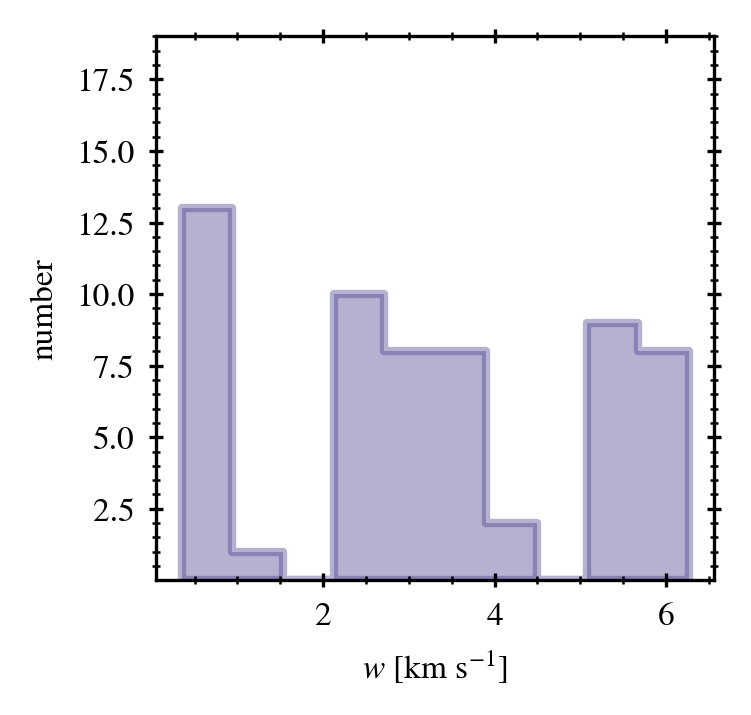

In [17]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()

ax.set_xlabel("$w$ [km s$^{-1}$]")
ax.set_ylabel("number")

ax.set_ylim(0.01, 19)

hist, bin_edges = np.histogram(phi_pm)
for k in range(len(hist)):
    hist[k] = hist[k] # / (np.log10(bins[k+1])-np.log10(bins[k]))/np.log(10)
left, right = bin_edges[:-1], bin_edges[1:]

X_Z = np.array([left,right]).T.flatten()
Y_Z = np.array([hist,hist]).T.flatten()

ax.fill_between(X_Z, 1e-6*np.ones(len(Y_Z)), Y_Z, color='darkslateblue', alpha=0.4, linewidth=2);

---

## Additional information on possible progenitors

In [18]:
additional_info_on_progenitors.keys()

Index(['natal_kick_id', 'mdon', 'macc', 'a', 'porb', 'e', 'number_of_models',
       'MT_case', 't_xrb', 'log_l_xrb', 'dot_m_acc', 'log_teff', 'log_l',
       'log_g', 'min_chi2'],
      dtype='object')

In [19]:
detail_progenitors.keys()

Index(['natal_kick_id', 'P_i', 'e_i', 'age', 'dt', 'M_donor', 'M_NS', 'P', 'e',
       'MT_case', 'rl_rel_donor', 'lg_wind_donor', 'Lx_wind', 'Lx_rlof',
       'R_donor', 'lg_Teff_donor', 'lg_L_donor'],
      dtype='object')

In [20]:
def binary_weight(m, q, logp, dm, dq, dlp):
    c_m1 = (np.power(m+dm, -1.35) - np.power(m-dm, -1.35)) / (np.power(150, -1.35) - np.power(8, -1.35))
    c_logp = (np.power(logp+dlp,0.45) - np.power(logp-dlp,0.45)) / (np.power(5.5,0.45) - np.power(0.15,0.45))
    c_q = 2 * dq / (0.9)
    return c_m1 * c_q * c_logp

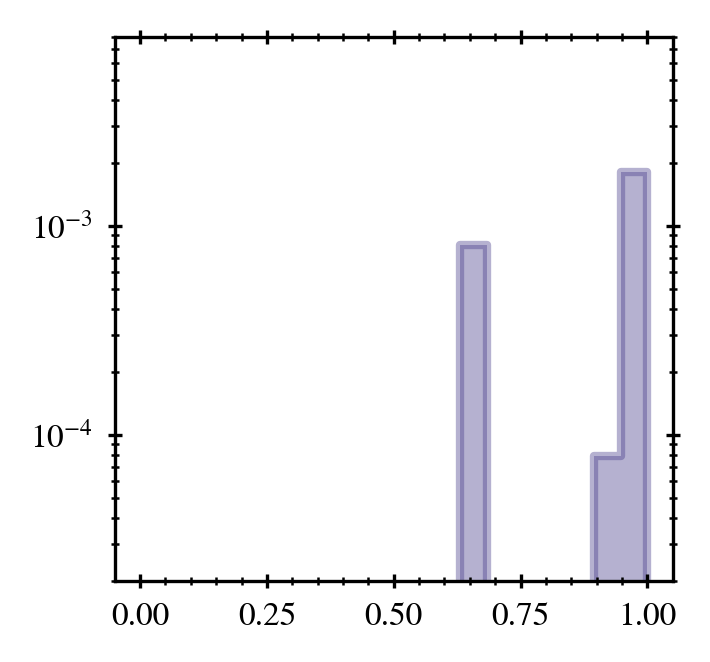

In [21]:
if use_paper_style:
    plt.style.use("../config/paper-style.mpl")
else:
    plt.style.use("../config/style.mpl")
fig, ax = plt.subplots()
ax.set_yscale("log")

ax.set_ylim([2e-5, 8e-3])

weight_binary = binary_weight(m=25, q=22/25, logp=np.log10(3), dm=0.2, dq=0.01, dlp=0.04)
scale = 10**38

bins = np.linspace(0, 1, 20)
Lx = detail_progenitors["Lx_wind"] + detail_progenitors["Lx_rlof"]
weights = (weight_binary * 0.01 / 3) * detail_progenitors["dt"]

hist, bin_edges = np.histogram(Lx/scale, bins=bins, weights=weights)
for k in range(len(hist)):
    hist[k] = hist[k] / (np.log10(bins[k+1])-np.log10(bins[k]))/np.log(10)
left, right = bin_edges[:-1], bin_edges[1:]

X_Z = np.array([left,right]).T.flatten()
Y_Z = np.array([hist,hist]).T.flatten()

ax.fill_between(X_Z, 1e-6*np.ones(len(Y_Z)), Y_Z, color='darkslateblue', alpha=0.4, linewidth=2);

---

## Population of interpolated binaries

In [22]:
import matplotlib.tri as tri

In [23]:
# triangular interpolator, not used for now
x = additional_info_on_progenitors["porb"]
y = additional_info_on_progenitors["e"]
z = additional_info_on_progenitors["min_chi2"]
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(x, y)
Zi = interpolator(Xi, Yi)

In [24]:
def interp_data():

    # debugging flag
    dbg = False

    # name of actual data file with MESA runs + a mask on models that are not important for us
    mask1 = additional_info_on_progenitors["number_of_models"] > 1
    data = additional_info_on_progenitors[mask1]

    # interpolated data will be saved into a dict
    interp_dict = dict()

    # controls for the grid of initial binary parameters for interp data
    nporbs = 1000
    de = 0.001

    # create 2D grid in the plane (P,e)
    P = additional_info_on_progenitors["porb"][mask1]
    e = additional_info_on_progenitors["e"][mask1]
    Pg = np.logspace(np.log10(np.min(P)), np.log10(np.max(P)), nporbs)
    eg = np.arange(0, 1, de)
    Pcoords, ecoords = np.meshgrid(Pg, eg)

    # loop over each column of the data to get interpolated results
    for key in data.keys():

        if key == "MT_case":
            continue

        Zdata = data[key]

        # interpolation method from scipy
        Zinterp = interpolate.griddata(
            np.vstack((P, e)).T, Zdata, (Pcoords, ecoords), method="linear"
        )

        # mask to remove NaN
        mask = ~np.isnan(Zinterp)

        interp_dict[key] = Zinterp[mask]

        if dbg:
            good_ones = np.count_nonzero(~np.isnan(Zinterp))
            total_ones = Zinterp.size
            print(
                f"fraction of interpolated progenitors for {key}, {good_ones}/{total_ones} ({100*good_ones/total_ones}%)"
            )

    # Pvals = Pcoords[mask]
    # evals = ecoords[mask]
    return pd.DataFrame(interp_dict)

In [25]:
DataInterp = interp_data()